<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Named Entity Recognition
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Finetuning on Chia (Albert-small-clinical-trials-randomshuffle)
  </div> 


  <div style="
      font-size: 15px; 
      line-height: 12px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Jean-baptiste AUJOGUE - Hybrid Intelligence
  </div> 


  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  December 2022
  </div>

<a id="TOC"></a>

#### Table Of Content

1. [Dataset](#data) <br>
2. [Albert finetuning](#albert) <br>
3. [Inference](#inference) <br>



#### Reference

- Hugginface full list of [tutorial notebooks](https://github.com/huggingface/transformers/tree/main/notebooks) (see also [here](https://huggingface.co/docs/transformers/main/notebooks#pytorch-examples))
- Huggingface full list of [training scripts](https://github.com/huggingface/transformers/tree/main/examples/pytorch)
- Huggingface [tutorial notebook](https://github.com/huggingface/notebooks/blob/main/examples/token_classification.ipynb) on token classification
- Huggingface [course](https://huggingface.co/course/chapter7/2?fw=tf) on token classification
- Huggingface [training script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/token-classification/run_ner.py) on token classification

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
import sys
import re
import random
import copy
import string

# data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import (
    Dataset, 
    DatasetDict,
    ClassLabel, 
    Features, 
    Sequence, 
    Value,
)
from transformers import DataCollatorForTokenClassification

# DL
import torch
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer,
    pipeline,
    set_seed,
)
import evaluate

# viz
from IPython.display import HTML

#### Transformers settings

In [32]:
transformers.__version__

'4.22.2'

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [34]:
# make training deterministic
set_seed(42)

#### Custom paths & imports

In [35]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'chia', 'chia-ner')
path_to_save = os.path.join(path_to_repo, 'saves', 'NER')
path_to_src  = os.path.join(path_to_repo, 'src')

In [36]:
sys.path.insert(0, path_to_src)

In [37]:
from nlptools.ner.preprocessing import tokenize_and_align_categories, create_labels
from nlptools.ner.metrics import compute_metrics
from nlptools.ner.postprocessing import parse_trf_ner_output, remove_entity_overlaps, correct_entity_boundaries
from nlptools.ner.visualization import render_ner_as_html

#### Constants

In [56]:
dataset_name = 'chia'
base_model_name = "albert-small-clinical-trials-randomshuffle"
final_model_name = "albert-small-clinical-trials-randomshuffle-chia"

<a id="data"></a>

# 1. Dataset

[Table of content](#TOC)

We generate a collection of instances of the `datasets.Dataset` class. 

Note that these are different from the fairly generic `torch.utils.data.Dataset` class. 

## 1.1 Load BIO corpus

[Table of content](#TOC)

In [39]:
df_bio = pd.read_csv(os.path.join(path_to_data, 'chia_bio.tsv'), sep = "\t")

df_bio.head(10)

,Id,Sequence_id,Mention,Category
0,NCT00050349_exc,NCT00050349_exc_0,Patients,O
1,NCT00050349_exc,NCT00050349_exc_0,with,O
2,NCT00050349_exc,NCT00050349_exc_0,symptomatic,B-Qualifier
3,NCT00050349_exc,NCT00050349_exc_0,,O
4,NCT00050349_exc,NCT00050349_exc_0,CNS,B-Condition
5,NCT00050349_exc,NCT00050349_exc_0,metastases,I-Condition
6,NCT00050349_exc,NCT00050349_exc_0,,O
7,NCT00050349_exc,NCT00050349_exc_0,or,O
8,NCT00050349_exc,NCT00050349_exc_0,leptomeningeal,B-Condition
9,NCT00050349_exc,NCT00050349_exc_0,involvement,I-Condition


For conveniance we create an instance of `ClassLabel` that keeps the class name - class index alignment in a single object :

In [40]:
class_labels = sorted(list(set(df_bio.Category.unique())))
class_labels = ClassLabel(names = class_labels)

In [41]:
label2id = class_labels._str2int
id2label = {i: l for l, i in label2id.items()}

## 1.2 Generate train / valid / test dataset

[Table of content](#TOC)

In [42]:
def get_item_list(df, grp_col, item_col):
    return df.groupby(grp_col).apply(lambda g: g[item_col].tolist()).tolist()



def convert_dataframe_to_dataset(df_bio):
    data = {
        'ids': df_bio.Sequence_id.unique().tolist(),
        'mentions': get_item_list(df_bio, 'Sequence_id', 'Mention'),
        'categories': get_item_list(df_bio, 'Sequence_id', 'Category'),
    }
    return data

In [43]:
# dataset separation: 800 trials for training, 100 trials for validation and 100 trials for testing
ids_bio = sorted(list(set(df_bio.Id.apply(lambda i: i.split('_')[0]))))

ids_trn, ids_dev = train_test_split(ids_bio, train_size = 0.8, random_state = 13, shuffle = True)
ids_dev, ids_tst = train_test_split(ids_dev, train_size = 0.5, random_state = 13, shuffle = True)

len(ids_bio), len(ids_trn), len(ids_dev), len(ids_tst)

(1000, 800, 100, 100)

In [44]:
df_trn = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_trn)]
df_dev = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_dev)]
df_tst = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_tst)]

In [45]:
dict_bio = convert_dataframe_to_dataset(df_bio)
dict_trn = convert_dataframe_to_dataset(df_trn)
dict_dev = convert_dataframe_to_dataset(df_dev)
dict_tst = convert_dataframe_to_dataset(df_tst)

In [46]:
# 'ner_tags': Sequence(class_labels),
features = Features({
    'ids': Value(dtype = 'string'), 
    'mentions': Sequence(Value(dtype = 'string')), 
    'categories': Sequence(Value(dtype = 'string')),
})

In [47]:
datasets = DatasetDict({
    'trn': Dataset.from_dict(dict_trn, features = features),
    'dev': Dataset.from_dict(dict_dev, features = features),
    'tst': Dataset.from_dict(dict_tst, features = features),
    'all': Dataset.from_dict(dict_bio, features = features),
})

## 1.3 Apply model-specific tokenization

[Table of content](#TOC)


In [48]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_to_save, base_model_name, 'tokenizer'))

We then perform the following operations:
- transform the `tokens` column of the datasets by tokenizing further each word into sub-word units
- transform the `labels` and `ner_tags` columns of the dataset to align with newly created tokens


In [49]:
B_I_mapping = {l: 'I'+l[1:] for l in class_labels.names if l.startswith('B-')}
B_I_mapping

{'B-Condition': 'I-Condition',
 'B-Device': 'I-Device',
 'B-Drug': 'I-Drug',
 'B-Measurement': 'I-Measurement',
 'B-Negation': 'I-Negation',
 'B-Observation': 'I-Observation',
 'B-Person': 'I-Person',
 'B-Procedure': 'I-Procedure',
 'B-Qualifier': 'I-Qualifier',
 'B-Temporal': 'I-Temporal',
 'B-Value': 'I-Value'}

In [50]:
tokenized_datasets = datasets.map(
    function = lambda examples: tokenize_and_align_categories(tokenizer, examples, B_I_mapping), 
    batched  = True,
)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.26ba/s]


By contrast to the generic BIO annotated data, this new data depends on the tokenizer, and is therefore _model-specific_.

<AxesSubplot: ylabel='Frequency'>

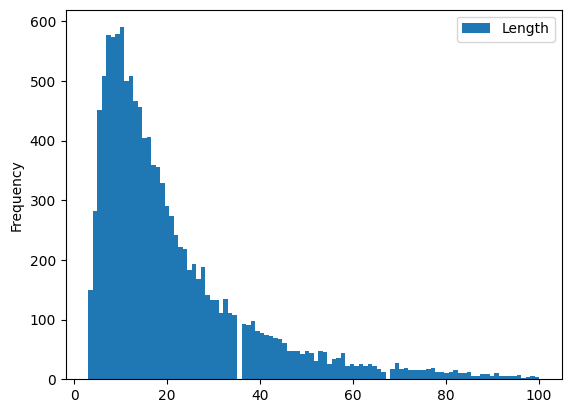

In [51]:
# distribution of lengths
lengths = [len(ts) for ts in tokenized_datasets['all']['input_ids']]
lengths = [l for l in lengths if l<= 100]

pd.DataFrame(lengths, columns = ['Length']).plot.hist(bins = 100)

In [52]:
for c in ['ids', 'mentions', 'categories', 'tokens', 'token_categories', 'input_ids']:
    print(c, ':', tokenized_datasets['tst'][c][0])

ids : NCT00122070_exc_0
mentions : ['Are', 'pregnant', ' ', 'or', 'lactating', '.']
categories : ['O', 'B-Condition', 'O', 'O', 'B-Condition', 'O']
tokens : ['[CLS]', '▁are', '▁pregnant', '▁or', '▁lactating', '▁', '.', '[SEP]']
token_categories : [None, 'O', 'B-Condition', 'O', 'B-Condition', 'O', 'O', None]
input_ids : [2, 45, 319, 27, 1899, 5, 11, 3]


## 1.4 Map categories to integers

[Table of content](#TOC)


In [53]:
tokenized_datasets = tokenized_datasets.map(
    function = lambda examples: create_labels(examples, class_labels), 
    batched  = True,
)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.38ba/s]


A new `labels` column is available in the dataset, and corresponds to the integer index, in the `class_labels` object, of the category of each token (or -100 if the category is None) :

In [54]:
for c in ['ids', 'mentions','categories', 'tokens', 'token_categories', 'input_ids', 'labels']:
    print(c, ':', tokenized_datasets['tst'][c][0])

ids : NCT00122070_exc_0
mentions : ['Are', 'pregnant', ' ', 'or', 'lactating', '.']
categories : ['O', 'B-Condition', 'O', 'O', 'B-Condition', 'O']
tokens : ['[CLS]', '▁are', '▁pregnant', '▁or', '▁lactating', '▁', '.', '[SEP]']
token_categories : [None, 'O', 'B-Condition', 'O', 'B-Condition', 'O', 'O', None]
input_ids : [2, 45, 319, 27, 1899, 5, 11, 3]
labels : [-100, 22, 0, 22, 0, 22, 22, -100]


<a id="albert"></a>

# 2. ALBERT finetuning

[Table of content](#TOC)

## 2.1 ALBERT model for Token Classification

[Table of content](#TOC)

In [57]:
model = AutoModelForTokenClassification.from_pretrained(
    os.path.join(path_to_save, base_model_name, 'model'),
    num_labels = len(class_labels.names),
    label2id = label2id,
    id2label = id2label,
    ignore_mismatched_sizes = True,
).to(device)

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at C:\Users\jb\Desktop\NLP\Internal - Transformers for NLP\saves\NER\albert-small-clinical-trials-randomshuffle\model and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 384]) in the checkpoint and torch.Size([23, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([23]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
model.num_parameters()

2538903

## 2.2. Finetuning

[Table of content](#TOC)

In [59]:
batch_size = 3  # GPU RAM = 8 GB

In [60]:
model = model.train()

In [61]:
args = TrainingArguments(
    os.path.join(path_to_save, "_checkpoints"),
    evaluation_strategy = "no",
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 7,
    weight_decay = 1e-4,
    save_strategy = 'no',
)

In [62]:
metric = evaluate.load("seqeval")

In [63]:
trainer = Trainer(
    model,
    args,
    data_collator = DataCollatorForTokenClassification(tokenizer),
    train_dataset = tokenized_datasets["all"],
    tokenizer = tokenizer,
    compute_metrics = lambda p: compute_metrics(p, metric, label_list),
)

Some remarks:

- The `data_collator` is the object used to batch elements of the training & evaluation datasets.
- The `tokenizer` is provided in order to automatically pad the inputs to the maximum length when batching inputs, and to have it saved along the model, which makes it easier to rerun an interrupted training or reuse the fine-tuned model.

In [64]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `AlbertForTokenClassification.forward` and have been ignored: tokens, ids, categories, token_categories, mentions. If tokens, ids, categories, token_categories, mentions are not expected by `AlbertForTokenClassification.forward`,  you can safely ignore this message.
C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12406
  Num Epochs = 7
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 28952
You're using a AlbertTokenizerFast tokenizer. Please note that with a

Step,Training Loss
500,1.827100
1000,1.215400
1500,1.092600
2000,0.974700
2500,0.909600
3000,0.876600
3500,0.854700
4000,0.850200
4500,0.845000
5000,0.790100




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=28952, training_loss=0.70540592017573, metrics={'train_runtime': 1100.7016, 'train_samples_per_second': 78.897, 'train_steps_per_second': 26.303, 'total_flos': 37932507263448.0, 'train_loss': 0.70540592017573, 'epoch': 7.0})

In [33]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `AlbertForTokenClassification.forward` and have been ignored: token_categories, mentions, ids, categories, tokens. If token_categories, mentions, ids, categories, tokens are not expected by `AlbertForTokenClassification.forward`,  you can safely ignore this message.
C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12406
  Num Epochs = 7
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 28952
You're using a AlbertTokenizerFast tokenizer. Please note that with a

Step,Training Loss
500,1.774400
1000,1.253900
1500,1.143600
2000,1.032700
2500,0.966200
3000,0.934100
3500,0.915300
4000,0.896400
4500,0.895600
5000,0.847800




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=28952, training_loss=0.7415224820021339, metrics={'train_runtime': 804.5347, 'train_samples_per_second': 107.941, 'train_steps_per_second': 35.986, 'total_flos': 37949332114974.0, 'train_loss': 0.7415224820021339, 'epoch': 7.0})

In [65]:
model = model.to('cpu')

In [66]:
tokenizer.save_pretrained(os.path.join(path_to_save, final_model_name, 'tokenizer'))
model.save_pretrained(os.path.join(path_to_save, final_model_name, 'model'))

tokenizer config file saved in C:\Users\jb\Desktop\NLP\Internal - Transformers for NLP\saves\NER\albert-small-clinical-trials-randomshuffle-chia\tokenizer\tokenizer_config.json
Special tokens file saved in C:\Users\jb\Desktop\NLP\Internal - Transformers for NLP\saves\NER\albert-small-clinical-trials-randomshuffle-chia\tokenizer\special_tokens_map.json
Configuration saved in C:\Users\jb\Desktop\NLP\Internal - Transformers for NLP\saves\NER\albert-small-clinical-trials-randomshuffle-chia\model\config.json
Model weights saved in C:\Users\jb\Desktop\NLP\Internal - Transformers for NLP\saves\NER\albert-small-clinical-trials-randomshuffle-chia\model\pytorch_model.bin


<a id="inference"></a>

# 3. Inference

[Table of content](#TOC)

In [36]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_to_save, final_model_name, 'tokenizer'))
model = AutoModelForTokenClassification.from_pretrained(os.path.join(path_to_save, final_model_name, 'model'))

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file C:\Users\jb\Desktop\NLP\Internal - Transformers for NLP\saves\NER\albert-small-clinical-trials-chia\model\config.json
Model config AlbertConfig {
  "_name_or_path": "C:\\Users\\jb\\Desktop\\NLP\\Internal - Transformers for NLP\\saves\\NER\\albert-small-clinical-trials-chia\\model",
  "architectures": [
    "AlbertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.05,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.05,
  "hidden_size": 384,
  "id2label": {
    "0": "B-Condition",
    "1": "B-Device",
    "2": "B-Drug",
    "3": "B-Measurement",
    "4": "B-Negation",
    "5": "B-Observation",
    "6": "B-Person",
    "7": "B-Procedure",
    "8"

In [67]:
ner = pipeline(
    task = 'ner', 
    model = model, 
    tokenizer = tokenizer,
    framework = 'pt',
    aggregation_strategy = 'simple',
)

In [68]:
sent = 'Polyneuropathy of other causes, including but not limited to hereditary demyelinating neuropathies, neuropathies secondary to infection or systemic disease, diabetic neuropathy, drug- or toxin-induced neuropathies, multifocal motor neuropathy, monoclonal gammopathy of uncertain significance, lumbosacral radiculoplexus neuropathy, pure sensory CIDP and acquired demyelinating symmetric (DADS) neuropathy (also known as distal CIDP).'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [38]:
sent = 'Polyneuropathy of other causes, including but not limited to hereditary demyelinating neuropathies, neuropathies secondary to infection or systemic disease, diabetic neuropathy, drug- or toxin-induced neuropathies, multifocal motor neuropathy, monoclonal gammopathy of uncertain significance, lumbosacral radiculoplexus neuropathy, pure sensory CIDP and acquired demyelinating symmetric (DADS) neuropathy (also known as distal CIDP).'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [38]:
sent = 'Polyneuropathy of other causes, including but not limited to hereditary demyelinating neuropathies, neuropathies secondary to infection or systemic disease, diabetic neuropathy, drug- or toxin-induced neuropathies, multifocal motor neuropathy, monoclonal gammopathy of uncertain significance, lumbosacral radiculoplexus neuropathy, pure sensory CIDP and acquired demyelinating symmetric (DADS) neuropathy (also known as distal CIDP).'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [69]:
sent = 'Adults and adolescent patients with a physician diagnosis of asthma ' +\
    'for ≥12 months, based on the Global Initiative for Asthma (GINA) 2014 Guidelines ' +\
    'and the followingcriteria: A) Existing treatment with medium to high dose ICS ' +\
    '(≥250 mcg of fluticasone propionate twice daily or equipotent ICS daily dosage ' +\
    'to a maximum of 2000 mcg/day of fluticasone propionate or equivalent) in combination ' +\
    'with a second controller (eg, LABA, LTRA) for at least 3 months with a stable dose ≥1 ' +\
    'month prior to Visit 1.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [39]:
sent = 'Adults and adolescent patients with a physician diagnosis of asthma ' +\
    'for ≥12 months, based on the Global Initiative for Asthma (GINA) 2014 Guidelines ' +\
    'and the followingcriteria: A) Existing treatment with medium to high dose ICS ' +\
    '(≥250 mcg of fluticasone propionate twice daily or equipotent ICS daily dosage ' +\
    'to a maximum of 2000 mcg/day of fluticasone propionate or equivalent) in combination ' +\
    'with a second controller (eg, LABA, LTRA) for at least 3 months with a stable dose ≥1 ' +\
    'month prior to Visit 1.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [39]:
sent = 'Adults and adolescent patients with a physician diagnosis of asthma ' +\
    'for ≥12 months, based on the Global Initiative for Asthma (GINA) 2014 Guidelines ' +\
    'and the followingcriteria: A) Existing treatment with medium to high dose ICS ' +\
    '(≥250 mcg of fluticasone propionate twice daily or equipotent ICS daily dosage ' +\
    'to a maximum of 2000 mcg/day of fluticasone propionate or equivalent) in combination ' +\
    'with a second controller (eg, LABA, LTRA) for at least 3 months with a stable dose ≥1 ' +\
    'month prior to Visit 1.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [70]:
sent = 'Biologics treatment: Cell-depleting agents, eg. Rituximab Drug within 6 months before baseline or until lymphocyte count returns to normal, Other biologics: within 5 half-lives or 16 weeks prior baseline.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [40]:
sent = 'Biologics treatment: Cell-depleting agents, eg. Rituximab Drug within 6 months before baseline or until lymphocyte count returns to normal, Other biologics: within 5 half-lives or 16 weeks prior baseline.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [40]:
sent = 'Biologics treatment: Cell-depleting agents, eg. Rituximab Drug within 6 months before baseline or until lymphocyte count returns to normal, Other biologics: within 5 half-lives or 16 weeks prior baseline.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [71]:
sents = '''Active hepatitis or patients with positive HBsAg, or patients with positive HBcAb plus positive HBV DNA, or positive HCV antibody (confirmed with presence of HCV RNA if needed) at screening.

History of alcohol or drug abuse within 2 years of the screening visit.

History of HIV infection or positive HIV serology at screening.

History of malignancy within 5 years before screening, except completely treated cervix carcinoma, completely treated and resolved non-metastatic squamous or basal cell carcinoma of the skin.

Infection requires systemic antibiotics, antivirals, antiparasitics, antiprotozoals, antifungals treatment within 2 weeks before baseline, superficial skin infections within 1 week before baseline visit.

Initiation AD treatment with prescription moisturizers or moisturizers containing  additives such as ceramide, hyaluronic acid, urea, or filaggrin degradation products during the screening period.

Known or suspected history of immunosuppression, including history of invasive opportunistic infections, despite infection resolution, or unusually frequent, recurrent, or prolonged infections.
'''
df_list = []
html = ''
for sent in sents.split('\n'):
    if sent.strip():
        ents = parse_trf_ner_output(ner(sent))
        ents = correct_entity_boundaries(sent, ents)
        ents = remove_entity_overlaps(ents)
        df_list.append(ents)
        html += render_ner_as_html(sent, ents)

df_ents = pd.concat(df_list, ignore_index = True)
HTML(html)

In [41]:
sents = '''Active hepatitis or patients with positive HBsAg, or patients with positive HBcAb plus positive HBV DNA, or positive HCV antibody (confirmed with presence of HCV RNA if needed) at screening.

History of alcohol or drug abuse within 2 years of the screening visit.

History of HIV infection or positive HIV serology at screening.

History of malignancy within 5 years before screening, except completely treated cervix carcinoma, completely treated and resolved non-metastatic squamous or basal cell carcinoma of the skin.

Infection requires systemic antibiotics, antivirals, antiparasitics, antiprotozoals, antifungals treatment within 2 weeks before baseline, superficial skin infections within 1 week before baseline visit.

Initiation AD treatment with prescription moisturizers or moisturizers containing  additives such as ceramide, hyaluronic acid, urea, or filaggrin degradation products during the screening period.

Known or suspected history of immunosuppression, including history of invasive opportunistic infections, despite infection resolution, or unusually frequent, recurrent, or prolonged infections.
'''
df_list = []
html = ''
for sent in sents.split('\n'):
    if sent.strip():
        ents = parse_trf_ner_output(ner(sent))
        ents = correct_entity_boundaries(sent, ents)
        ents = remove_entity_overlaps(ents)
        df_list.append(ents)
        html += render_ner_as_html(sent, ents)

df_ents = pd.concat(df_list, ignore_index = True)
HTML(html)

In [41]:
sents = '''Active hepatitis or patients with positive HBsAg, or patients with positive HBcAb plus positive HBV DNA, or positive HCV antibody (confirmed with presence of HCV RNA if needed) at screening.

History of alcohol or drug abuse within 2 years of the screening visit.

History of HIV infection or positive HIV serology at screening.

History of malignancy within 5 years before screening, except completely treated cervix carcinoma, completely treated and resolved non-metastatic squamous or basal cell carcinoma of the skin.

Infection requires systemic antibiotics, antivirals, antiparasitics, antiprotozoals, antifungals treatment within 2 weeks before baseline, superficial skin infections within 1 week before baseline visit.

Initiation AD treatment with prescription moisturizers or moisturizers containing  additives such as ceramide, hyaluronic acid, urea, or filaggrin degradation products during the screening period.

Known or suspected history of immunosuppression, including history of invasive opportunistic infections, despite infection resolution, or unusually frequent, recurrent, or prolonged infections.
'''
df_list = []
html = ''
for sent in sents.split('\n'):
    if sent.strip():
        ents = parse_trf_ner_output(ner(sent))
        ents = correct_entity_boundaries(sent, ents)
        ents = remove_entity_overlaps(ents)
        df_list.append(ents)
        html += render_ner_as_html(sent, ents)

df_ents = pd.concat(df_list, ignore_index = True)
HTML(html)

[Table of content](#TOC)